In [38]:
import pandas as pd
import numpy as np
import os 
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import csv

import optuna
import ast
import datetime
import pickle
import shap

from sklearn.metrics import auc,log_loss,accuracy_score,roc_auc_score

## Defining the paths of the input and the hiperparameters

In [7]:
#path to data files
notebook_path = os.getcwd()
project_path = notebook_path[0:len(notebook_path)-18]+"data/"
project_code_path = notebook_path[0:len(notebook_path)-18]+"code/"

OPTIMIZE_FILE = project_path+ 'optuna_scores.csv' #path where it will be saved the hipterparamether trials
SEED = 42
NJOBS = 60

## Reading the data

In [15]:
df = pd.read_pickle(project_path+'clened_df_toTrain.pkl')

In [18]:
df = df.loc[:,~df.columns.isin(["userId","movieId","rating"])]

In [19]:
df.dtypes

year_month                                  int64
target_var                                  int64
Sci-Fi                                      int64
Horror                                      int64
Action                                      int64
Musical                                     int64
Documentary                                 int64
Romance                                     int64
Film-Noir                                   int64
Crime                                       int64
Animation                                   int64
Drama                                       int64
Adventure                                   int64
Mystery                                     int64
Fantasy                                     int64
War                                         int64
IMAX                                        int64
Comedy                                      int64
Children                                    int64
Thriller                                    int64


## Dividing train and test and validation

Lets have a train, test of 4 months (80% for train and 20 for test) and a month of validation(Out of time).

In [20]:
train_test_df = df.loc[df["year_month"]<201503,~df.columns.isin(["year_month"])]
validation_df = df.loc[df["year_month"]==201503,~df.columns.isin(["year_month"])]

In [21]:
train_test_df

,target_var,Sci-Fi,Horror,Action,Musical,Documentary,Romance,Film-Noir,Crime,Animation,Drama,Adventure,Mystery,Fantasy,War,IMAX,Comedy,Children,Thriller,Western,last_1_months_movie_rating,last_1_months_movie_rating_counts,mean_3_months_movie_rating,mean_6_months_movie_rating,last_1_month_per_3_months_movie_rating,last_1_month_per_6_months_movie_rating,last_6_months_weighted_rating,last_1_months_genre_rating,last_1_months_genre_rating_counts,mean_3_months_genre_rating,mean_6_months_genre_rating,last_1_month_per_3_months_genre_rating,last_1_month_per_6_months_genre_rating,last_1_months_user_rating,last_1_months_user_rating_counts,mean_3_months_user_rating,mean_6_months_user_rating,last_1_month_per_3_months_user_rating,last_1_month_per_6_months_user_rating
0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,3.856164,146.000000,3.945138,3.904015,0.977447,0.987743,3.942630,3.116378,1358.200000,3.146666,3.242472,0.990781,0.961358,3.584819,164.425009,3.537247,3.500329,0.994607,0.996374
1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,3.770270,185.000000,3.724585,3.820718,1.012266,0.986796,3.832747,3.284891,2355.666667,3.343781,3.400271,0.982860,0.966030,3.584819,164.425009,3.537247,3.500329,0.994607,0.996374
2,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3.866279,258.000000,3.953669,4.006939,0.977897,0.964896,3.825609,3.106176,1309.666667,3.124029,3.214912,0.994324,0.966209,3.584819,164.425009,3.537247,3.500329,0.994607,0.996374
3,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,1,0,1,0,0,3.714286,84.000000,3.901607,3.927841,0.951989,0.945630,3.619601,3.188801,1292.333333,3.238047,3.318860,0.985293,0.960907,3.584819,164.425009,3.537247,3.500329,0.994607,0.996374
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,3.900810,247.000000,3.982148,4.055195,0.979574,0.961929,3.922061,3.383728,2646.500000,3.465100,3.499553,0.976535,0.966924,3.584819,164.425009,3.537247,3.500329,0.994607,0.996374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354995,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,3.841463,41.000000,4.020065,4.026188,0.955573,0.954119,4.037064,3.391114,1393.000000,3.382888,3.368958,1.002431,1.006709,4.333333,3.000000,4.486111,4.284722,0.965944,1.011345
354996,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,3.993421,76.000000,3.902809,3.934357,1.023217,1.015012,3.862862,3.389731,687.000000,3.345587,3.333375,1.013202,1.016888,4.500000,2.000000,4.291667,4.229167,1.048544,1.064039
354997,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.678514,32.140486,3.654632,3.665282,1.008574,1.007407,3.943211,3.359148,412.500000,3.317876,3.282185,1.012319,1.023338,4.500000,2.000000,4.291667,4.229167,1.048544,1.064039
354998,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4.008065,124.000000,4.058135,3.665282,0.987662,1.007407,3.861979,3.334103,919.333333,3.305795,3.276084,1.008528,1.017695,4.500000,2.000000,4.291667,4.229167,1.048544,1.064039


In [23]:
X_train, X_test, y_train, y_test = train_test_split(train_test_df.loc[:,~train_test_df.columns.isin(["target_var"])],
                                                    train_test_df[["target_var"]], test_size=0.2, random_state=SEED)

## Defining the hyperparameter space to look for the best model

Lightgbm is a tree boosting library implemented by Microsoft that has high accuracy and can reach to its optimum in a fast time. Tree base algorithms like lightgbm xgboost and catboost had demonstrated in many competitions to outperform other type of models  like neural networks and lineal models for task that aren't for images, text and not have thousands of parameters.

The next hyperparameters will be optimze with optuna that uses TPE(Tree-structured Parzen Estimator),an efficient search methods using stochastic models, that for each trial will try to look for the best next space to look for. A nice thing about this package is the visualization of the space searched and the metric observations in each trial.

In [24]:
N_EST = 1000
INT_PARAMS = ['n_estimators', 'max_leaves', 'max_depth', 'subsample_for_bin', 'min_data_in_leaf', 'subsample_freq'
              , 'random_state', 'n_jobs', 'num_leaves']

In [43]:
def objective_optimze(trial):

    params = {'n_estimators': N_EST
             , 'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.2)
             , 'num_leaves': trial.suggest_int('num_leaves', 7, 255)
             , 'max_depth': -1
             , 'subsample': trial.suggest_uniform('subsample', 0.75, 1)
             , 'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.8, 1)
             , 'min_child_weight': trial.suggest_uniform('min_child_weight', 1e-1, 200)
             , 'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 3.0)
             , 'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 3.0)
             , 'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-2, 100) #aka gamma in xgboost
             , 'max_delta_step': trial.suggest_uniform('max_delta_step', 0, 100)
             , 'subsample_for_bin': trial.suggest_int('subsample_for_bin', 50*1000, 300*1000)
             , 'subsample_freq': trial.suggest_int('subsample_freq', 1, 10)
             , 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, int(0.05 * X_train.shape[0]))
              
             , 'random_state': SEED
             , 'n_jobs' : NJOBS
            }
    
    start_time = datetime.datetime.now()

    model = LGBMClassifier(**params)
    model.fit(X_train, y_train, eval_metric=['binary_logloss'], verbose=False
            , eval_set=[(X_test, y_test)], early_stopping_rounds=100)
    
    train_time = datetime.datetime.now() - start_time

    pred_val = model.predict(X_test)
    pred_train = model.predict(X_train)
    
    auc_test = roc_auc_score(y_test, pred_val)
    auc_train = roc_auc_score(y_train, pred_train)
    
    with open(OPTIMIZE_FILE, 'a') as f:
        writer = csv.writer(f)
        writer.writerow([params, auc_test, auc_train, train_time])
    
    return auc_test

In [44]:
with open(OPTIMIZE_FILE, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['params', 'auc_test', 'auc_train', 'train_time'])

In [45]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_optimze, n_trials=30, show_progress_bar=True, n_jobs=1)

1
 10%|█         | 3/30 [02:25<17:11, 38.21s/it][I 2021-04-11 13:19:08,470] Trial 2 finished with value: 0.6672694326233609 and parameters: {'learning_rate': 0.16117324232087654, 'num_leaves': 204, 'subsample': 0.9952357818068703, 'colsample_bytree': 0.9947752492766004, 'min_child_weight': 54.3399751871382, 'reg_alpha': 0.0062782039970959635, 'reg_lambda': 1.7732299950201433, 'min_split_gain': 1.4984466969976866, 'max_delta_step': 77.73482510386255, 'subsample_for_bin': 104417, 'subsample_freq': 8, 'min_data_in_leaf': 8671}. Best is trial 0 with value: 0.6726508063773151.
[LightGBM] [Warning] min_data_in_leaf is set=1243, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1243
 13%|█▎        | 4/30 [03:35<22:03, 50.90s/it][I 2021-04-11 13:20:18,834] Trial 3 finished with value: 0.6721539636324532 and parameters: {'learning_rate': 0.1729066363414632, 'num_leaves': 106, 'subsample': 0.9808147590854422, 'colsample_bytree': 0.8277108557309096, 'min_child_weight': 108.915

In [47]:
print('Best parameters:\n')
print(study.best_params)
print('Best auc:\n')
print(study.best_value)

Best parameters:

{'learning_rate': 0.0598818380781255, 'num_leaves': 51, 'subsample': 0.9476962184790506, 'colsample_bytree': 0.8047843153701006, 'min_child_weight': 142.19309706768772, 'reg_alpha': 0.03750945925616626, 'reg_lambda': 0.005425505991139322, 'min_split_gain': 0.19755645206408207, 'max_delta_step': 22.62093380922365, 'subsample_for_bin': 225302, 'subsample_freq': 3, 'min_data_in_leaf': 288}
Best auc:

0.6749969193020929


In [55]:
## Vizualization of the hyperparameter space

In [48]:
optuna.visualization.plot_optimization_history(study)

In [49]:
optuna.visualization.plot_slice(study)

In [51]:
info_opt = pd.read_csv(OPTIMIZE_FILE)

info_opt_all = pd.DataFrame([ast.literal_eval(info_opt.loc[i, 'params']) for i in range(info_opt.shape[0])])
info_opt_all.insert(0, 'auc_test', info_opt['auc_test'])
info_opt_all.insert(1, 'auc_train', info_opt['auc_train'])
info_opt_all.insert(2, 'diff_auc', info_opt['auc_train'] - info_opt['auc_test'])
info_opt_all

,auc_test,auc_train,diff_auc,n_estimators,learning_rate,num_leaves,max_depth,subsample,colsample_bytree,min_child_weight,reg_alpha,reg_lambda,min_split_gain,max_delta_step,subsample_for_bin,subsample_freq,min_data_in_leaf,random_state,n_jobs
0,0.672651,0.682361,0.009710,1000,0.041249,34,-1,0.955111,0.827433,169.049078,0.898266,0.001229,0.586532,26.275882,257149,5,2729,42,60
1,0.663976,0.666992,0.003016,1000,0.020533,51,-1,0.987311,0.902682,18.676381,0.001208,0.015815,8.397113,34.327049,157537,10,8957,42,60
2,0.667269,0.671667,0.004398,1000,0.161173,204,-1,0.995236,0.994775,54.339975,0.006278,1.773230,1.498447,77.734825,104417,8,8671,42,60
3,0.672154,0.699929,0.027775,1000,0.172907,106,-1,0.980815,0.827711,108.915332,0.007245,0.315216,0.017184,71.561024,229866,8,1243,42,60
4,0.663549,0.666350,0.002801,1000,0.155111,94,-1,0.750912,0.879237,179.092848,0.004543,0.113681,8.775377,37.913480,101028,8,6996,42,60
5,0.666162,0.668906,0.002743,1000,0.052601,253,-1,0.935829,0.944166,50.795058,0.001471,0.033842,4.272153,2.034670,82320,1,7076,42,60
6,0.672741,0.689978,0.017238,1000,0.030978,62,-1,0.943611,0.834111,86.674106,0.070461,0.004145,0.185341,29.847476,56678,4,2056,42,60
7,0.663718,0.665825,0.002107,1000,0.091343,80,-1,0.903609,0.863415,38.513159,2.006643,0.733734,25.661622,83.665002,283233,3,6757,42,60
8,0.672620,0.687606,0.014986,1000,0.075915,233,-1,0.888626,0.914530,55.457855,0.004017,0.333261,0.657126,86.521586,143321,7,3062,42,60
9,0.670356,0.675856,0.005501,1000,0.038063,11,-1,0.764659,0.982986,53.155514,1.069578,0.005517,0.908370,68.436771,223206,4,1866,42,60


## Training with the best params

In [57]:
best_eval = 12

best_params = {'random_state': SEED
               , 'n_jobs' : NJOBS
               , 'n_estimators': N_EST
              }
best_params.update(dict(info_opt_all.drop(['auc_test', 'auc_train', 'diff_auc'], axis=1).loc[best_eval,:]))
for k, v in best_params.items():
    if k in INT_PARAMS:
        best_params[k] = int(v)
best_params

{'random_state': 42,
 'n_jobs': 60,
 'n_estimators': 1000,
 'learning_rate': 0.0598818380781255,
 'num_leaves': 51,
 'max_depth': -1,
 'subsample': 0.9476962184790506,
 'colsample_bytree': 0.8047843153701006,
 'min_child_weight': 142.19309706768772,
 'reg_alpha': 0.03750945925616626,
 'reg_lambda': 0.005425505991139322,
 'min_split_gain': 0.19755645206408207,
 'max_delta_step': 22.62093380922365,
 'subsample_for_bin': 225302,
 'subsample_freq': 3,
 'min_data_in_leaf': 288}

In [54]:
best_params['n_estimators'] = 1000
lgb = LGBMClassifier(**best_params)
lgb.fit(X_train, y_train, eval_metric=['binary_logloss'], verbose=200, early_stopping_rounds=50
             , eval_set=[(X_train, y_train), (X_test, y_test)])

[LightGBM] [Warning] min_data_in_leaf is set=288, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=288
Training until validation scores don't improve for 50 rounds
[200]	training's binary_logloss: 0.589761	valid_1's binary_logloss: 0.599646
[400]	training's binary_logloss: 0.580859	valid_1's binary_logloss: 0.597771
[600]	training's binary_logloss: 0.57422	valid_1's binary_logloss: 0.59717
Early stopping, best iteration is:
[660]	training's binary_logloss: 0.572446	valid_1's binary_logloss: 0.597084


LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.8047843153701006, importance_type='split',
               learning_rate=0.0598818380781255,
               max_delta_step=22.62093380922365, max_depth=-1,
               min_child_samples=20, min_child_weight=142.19309706768772,
               min_data_in_leaf=288, min_split_gain=0.19755645206408207,
               n_estimators=1000, n_jobs=60, num_leaves=51, objective=None,
               random_state=42, reg_alpha=0.03750945925616626,
               reg_lambda=0.005425505991139322, silent=True,
               subsample=0.9476962184790506, subsample_for_bin=225302,
               subsample_freq=3)

## Prediction in validation out of time

In [64]:
pred_val = lgb.predict(validation_df.loc[:, ~validation_df.columns.isin(["target_var"])])
    
auc_val = roc_auc_score(validation_df["target_var"], pred_val)
logloss_val = log_loss(validation_df["target_var"], pred_val)

In [67]:
print("Validation AUC: "+str(auc_test)+"\nValidation logloss: "+str(logloss_val))

Validation AUC: 0.6083391766028279
Validation logloss: 13.3439633389118


As we can see. Even if the metrics on test sample were not so different from the train set, the validation metrics for the last month were less efective. This could be because The users we saw on the training set were different for the month for validation and different movies were rated. We could include more months to the training or create new variables.

Lets save the model:

In [68]:
filehandler = open(project_path+'model1_lgbm.pkl',"wb")
pickle.dump(lgb,filehandler)
filehandler.close()

## Explaning the model

In [98]:
%time explainer = shap.TreeExplainer(lgb)
shap_values = explainer.shap_values(X_test)

CPU times: user 1.38 s, sys: 99.2 ms, total: 1.48 s
Wall time: 1.52 s


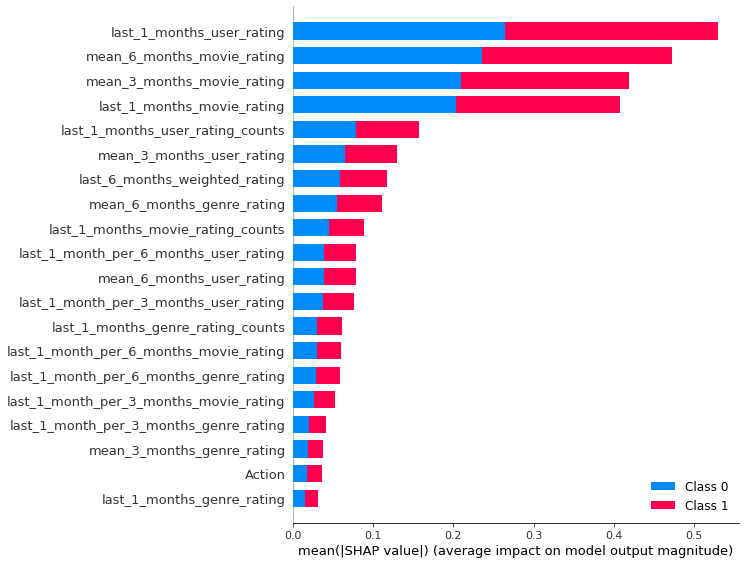

In [99]:
shap.summary_plot(shap_values, X_test)

## Explaning the 5 most important variables in the model

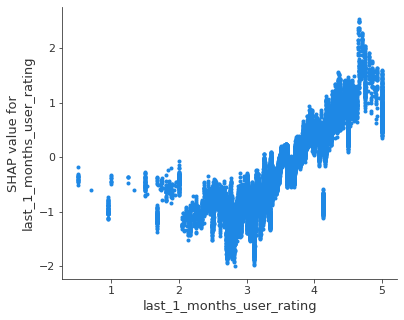

In [95]:
shap.dependence_plot("last_1_months_user_rating", shap_values[1], X_test,interaction_index=None)

For high values in the mean of the last month of the user, higher is the chance of having a high rate. For values under 3, it is not clearly the trend, because, for rates less than or equal than 1, it not gives a less importance as ratings near 3. 
An hypothesis can be that users that rate 3 in there movies are more confidence on giving rates less than 4, but for 1, could be atypical users that only rate in one month 

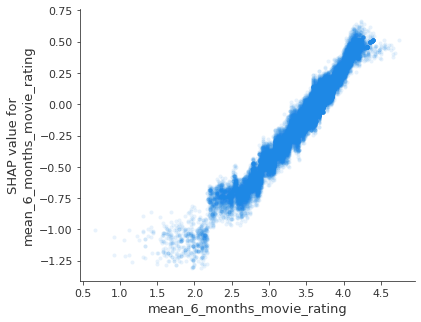

In [84]:
shap.dependence_plot("mean_6_months_movie_rating", shap_values[1], X_test,interaction_index=None,alpha=0.1)

Unlike the preview plot, there exist a direct relation between the mean of the rates in the last 6 months of a movie and the impact in the trend of having a high score

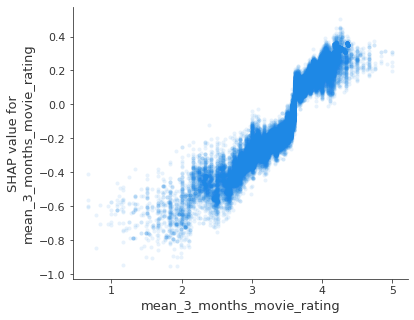

In [83]:
shap.dependence_plot("mean_3_months_movie_rating", shap_values[1], X_test,interaction_index=None,alpha=0.1)


There exist a direct relation between the mean of the rates in the last 3 months of a movie and the impact in the trend of having a high score, but for lesser scores, the impact stops to meaningful for the prediction.

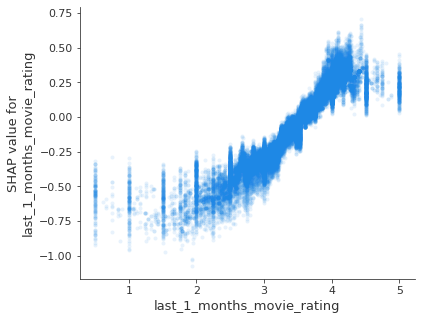

In [88]:
shap.dependence_plot("last_1_months_movie_rating", shap_values[1], X_test,interaction_index=None,alpha=0.1)

The impact that has the mean rating of a movie in the last month has a positive impact on having a high score but if there are unique rates like exactly 1 or 5, there is some variance in the impact of the variable 

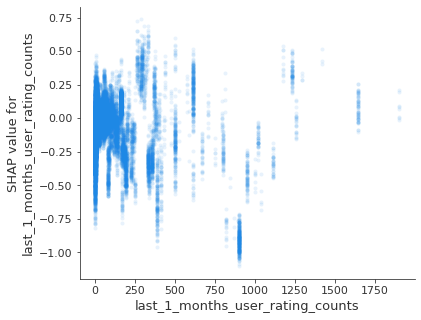

In [127]:
shap.dependence_plot("last_1_months_user_rating_counts", shap_values[1], X_test,interaction_index=None,alpha=0.1)

For fifth important variable we have the counts of times a user has rate movies in the last month. There outliers that could be errors and can be checked because it seems difficult to a user to rate so much movies. Lets see the plot excluding values higher than the percentile 95

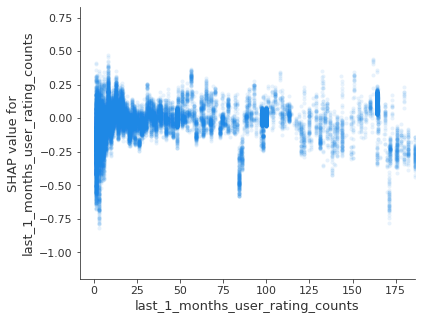

In [132]:
shap.dependence_plot("last_1_months_user_rating_counts", shap_values[1], X_test,interaction_index=None,alpha=0.1, xmax="percentile(95)")

There is not clear trend on this varible and surely there are interactions with other variables that impact on output of the model

## Conclusions

This is a good challenge to incorporate what I have learn on data exploration, cleaning, modeling and interpreting. The model didn't had good results as other datasets that I have work, and in this kind of data is when we can incorporate creative variables, transformations on the response variable or modify some parameters in model so the prediction can improve.


First, as we could visualize in the the EDA, there are a lot of users that only exist in some months and this can incorporate noise to the model. Maybe creating some more variables that can differentiate users with some counts and the ones that usually rate, can have an impact on the rate a user gives to a movie.

Having more time, I could implement variables that can help in having some community indicators of the movies or users: Users that utilize some kind of tag, view the relation between that users and other users that have used the tag, not only the weighted tag for the movie. For a period of time before the training, making k-means to find clusters of users and view the difference between the rating of that users and the cluster. For movies, there could exist a graph of importance of tags where for some movie, it could have the mean of rating on all it neighbors of similar movies with relevant tags. 

Another thing we can do to improve the accuracy of the model, is incorporate months and not only the 4 months that I used. This can be seen in the validation dataset, the metrics weren't as good as the ones in training and test.

And finally, use other models and compare them between them.